In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
spotify_songs_df = pd.read_csv('spotify-2023.csv', encoding='latin-1')

In [3]:
# Null values in columns of float type
null_float_columns = spotify_songs_df.select_dtypes(include=['float']).isnull().sum()
print("Null values in columns of float type:")
print(null_float_columns)

# Null values in columns of object type
null_text_columns = spotify_songs_df.select_dtypes(include=['object']).isnull().sum()
print("\nNull values in columns of object type:")
print(null_text_columns)

# Null values in columns of integer type
null_int_columns = spotify_songs_df.select_dtypes(include=['int']).isnull().sum()
print("\nNull values in columns of integer type:")
print(null_int_columns)

Null values in columns of float type:
Series([], dtype: float64)

Null values in columns of object type:
track_name              0
artist(s)_name          0
streams                 0
in_deezer_playlists     0
in_shazam_charts       50
key                    95
mode                    0
dtype: int64

Null values in columns of integer type:
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
in_apple_playlists      0
in_apple_charts         0
in_deezer_charts        0
bpm                     0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


In [4]:
#Converts non-numeric values to NaN
spotify_songs_df['in_shazam_charts'] = pd.to_numeric(spotify_songs_df['in_shazam_charts'], errors='coerce')
#Calculates the average of the numerical values in the column
mean_shazam_charts = spotify_songs_df['in_shazam_charts'].mean()
#Replace the NaN values with the calculated mean
spotify_songs_df['in_shazam_charts'].fillna(mean_shazam_charts, inplace=True)
print("Mean of in_shazam_charts:", mean_shazam_charts)

Mean of in_shazam_charts: 51.176339285714285


**Modelling**

I want to build a model that predicts a song's popularity based on its musical characteristics.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [6]:
spotify_songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   artist(s)_name        953 non-null    object 
 2   artist_count          953 non-null    int64  
 3   released_year         953 non-null    int64  
 4   released_month        953 non-null    int64  
 5   released_day          953 non-null    int64  
 6   in_spotify_playlists  953 non-null    int64  
 7   in_spotify_charts     953 non-null    int64  
 8   streams               953 non-null    object 
 9   in_apple_playlists    953 non-null    int64  
 10  in_apple_charts       953 non-null    int64  
 11  in_deezer_playlists   953 non-null    object 
 12  in_deezer_charts      953 non-null    int64  
 13  in_shazam_charts      953 non-null    float64
 14  bpm                   953 non-null    int64  
 15  key                   8

To do the model I don't have to consider all the variables but only some, so I prefer to create a copy of the dataframe and use it to do the liner regression and delete some columns that I don't need for the model.

In [7]:
spotify_songs_copy_df = spotify_songs_df.copy()

In [8]:
spotify_songs_copy_df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

In [9]:
spotify_songs_copy_df.drop(columns= ['track_name', 'artist(s)_name','artist_count','released_year','released_month', 'released_day','in_spotify_playlists', 'in_spotify_charts','in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts','key','mode'], inplace=True)

In [10]:
spotify_songs_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   streams             953 non-null    object
 1   bpm                 953 non-null    int64 
 2   danceability_%      953 non-null    int64 
 3   valence_%           953 non-null    int64 
 4   energy_%            953 non-null    int64 
 5   acousticness_%      953 non-null    int64 
 6   instrumentalness_%  953 non-null    int64 
 7   liveness_%          953 non-null    int64 
 8   speechiness_%       953 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 67.1+ KB


In [11]:
spotify_songs_copy_df.head(3)

,streams,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,141381703,125,80,89,83,31,0,8,4
1,133716286,92,71,61,74,7,0,10,4
2,140003974,138,51,32,53,17,0,31,6


In [12]:
import re
# Function to extract numerical value from a string
def extract_numeric_value(entry):
    if isinstance(entry, str):
        numeric_match = re.search(r'\d+\.*\d*', entry)
        if numeric_match:
            return float(numeric_match.group())
        else:
            return np.nan
    elif isinstance(entry, (int, float)):
        return float(entry)
    else:
        return np.nan

# Applies the function to extract numeric or NaN values from the column
spotify_songs_copy_df['streams_numeric_cleaned'] = spotify_songs_copy_df['streams'].apply(extract_numeric_value)

#  Check the first few lines to see if cleaning was successful
print(spotify_songs_copy_df[['streams', 'streams_numeric_cleaned']].head())


     streams  streams_numeric_cleaned
0  141381703              141381703.0
1  133716286              133716286.0
2  140003974              140003974.0
3  800840817              800840817.0
4  303236322              303236322.0


In [14]:
#Function to check whether a string is concatenated (has more than one characteristic type)
def is_concatenated(entry):
    return bool(re.search(r'[A-Za-z]', entry)) and bool(re.search(r'\d', entry))

# Filter and remove rows with concatenated values in the 'streams' column
spotify_songs_copy_df = spotify_songs_copy_df[~spotify_songs_copy_df['streams'].apply(is_concatenated)]

# Remove the 'streams' column from the DataFrame
spotify_songs_copy_df = spotify_songs_copy_df.drop(columns=['streams'])

x = spotify_songs_copy_df.drop(['streams_numeric_cleaned'], axis = 1) #to make the prediction I delete the column I need to predict
y = spotify_songs_copy_df.streams_numeric_cleaned.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #80% of X and Y are test and 20% are train



KeyError: 'streams'

In [16]:
#Inizialize an empty list to store the sum squared of the distance for each number of clusters
Sum_of_squared_distances = []
#Fit the KMeans model to the data with a range of different numbers of clusters
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(spotify_songs_copy_df)
    Sum_of_squared_distances.append(km.inertia_)

In [17]:
for n_clusters in range(2,15):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(spotify_songs_copy_df)
    centers = clusterer.cluster_centers_

    score = silhouette_score (spotify_songs_copy_df, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.7415657882311354)
For n_clusters = 3, silhouette score is 0.6715605260219585)
For n_clusters = 4, silhouette score is 0.639180935701872)
For n_clusters = 5, silhouette score is 0.6291177665427324)
For n_clusters = 6, silhouette score is 0.582626949526874)
For n_clusters = 7, silhouette score is 0.5895243132781444)
For n_clusters = 8, silhouette score is 0.571722979907596)
For n_clusters = 9, silhouette score is 0.549399898154952)
For n_clusters = 10, silhouette score is 0.5434357618439625)
For n_clusters = 11, silhouette score is 0.5542587344001666)
For n_clusters = 12, silhouette score is 0.5455648732970346)
For n_clusters = 13, silhouette score is 0.5475818833504227)
For n_clusters = 14, silhouette score is 0.5400774910964656)


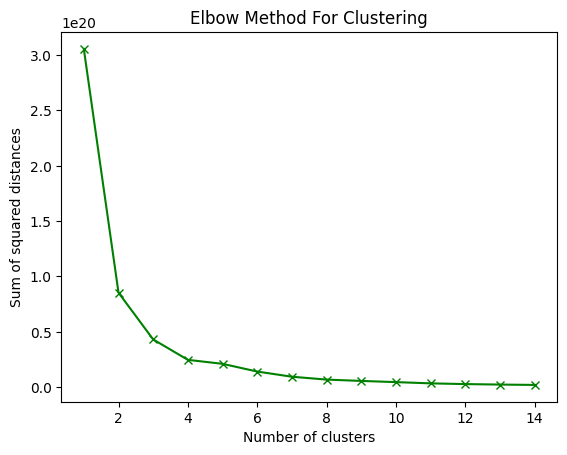

In [18]:
#Plot the sum squared distances for each number of cluster
plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Clustering')
plt.show()

In [19]:
#inizialize the kmeans model, with k=4 because we can see an elbow point in corrispondence of 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(spotify_songs_copy_df)

KMeans(n_clusters=4)

In [20]:
#To generate the clusters with the KMeans algorithm, we can use the predict() method on the fitted KMeans model
clusters=kmeans.predict(spotify_songs_copy_df)
print(clusters[:10])

[3 3 3 0 3 3 0 3 3 0]


In [21]:
from sklearn.metrics import silhouette_score
#Evaluate the quality of the generated clusters
## Calculate the silhouette score for the generated clusters
#remark silhouette index go from -1 and 1
silhouette_score(spotify_songs_copy_df,clusters)

0.639180935701872

In [22]:
# PCA to reduce our data to 2 dimensions for visualisation
from sklearn.decomposition import PCA
y_kmeans = kmeans.predict(spotify_songs_copy_df)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(spotify_songs_copy_df)

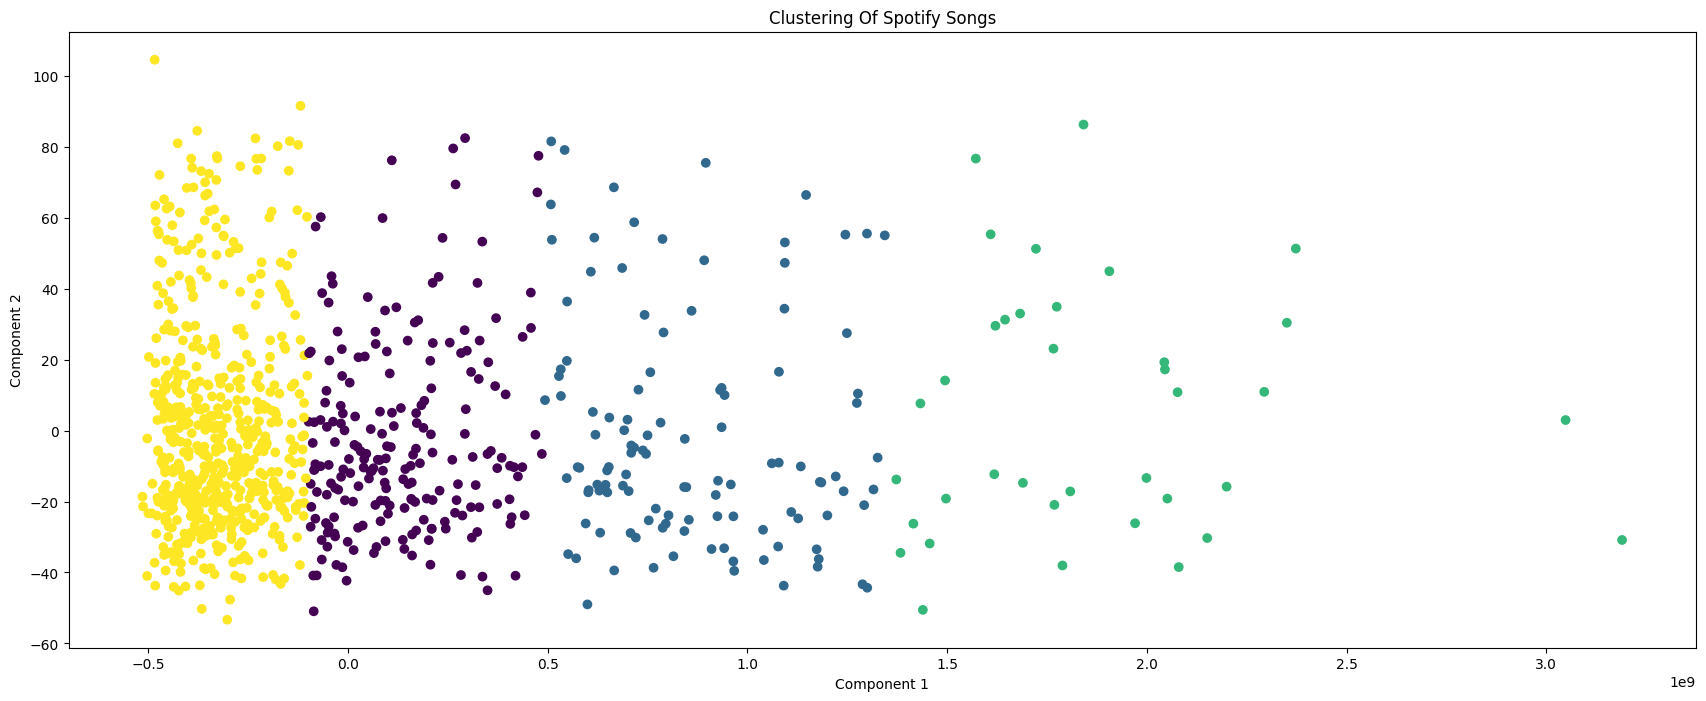

In [23]:

#plot
# Plot the data points on a scatter plot
# Coloring the data points according to their cluster assignment
plt.figure(figsize=(21,8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters)
plt.title('Clustering Of Spotify Songs')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

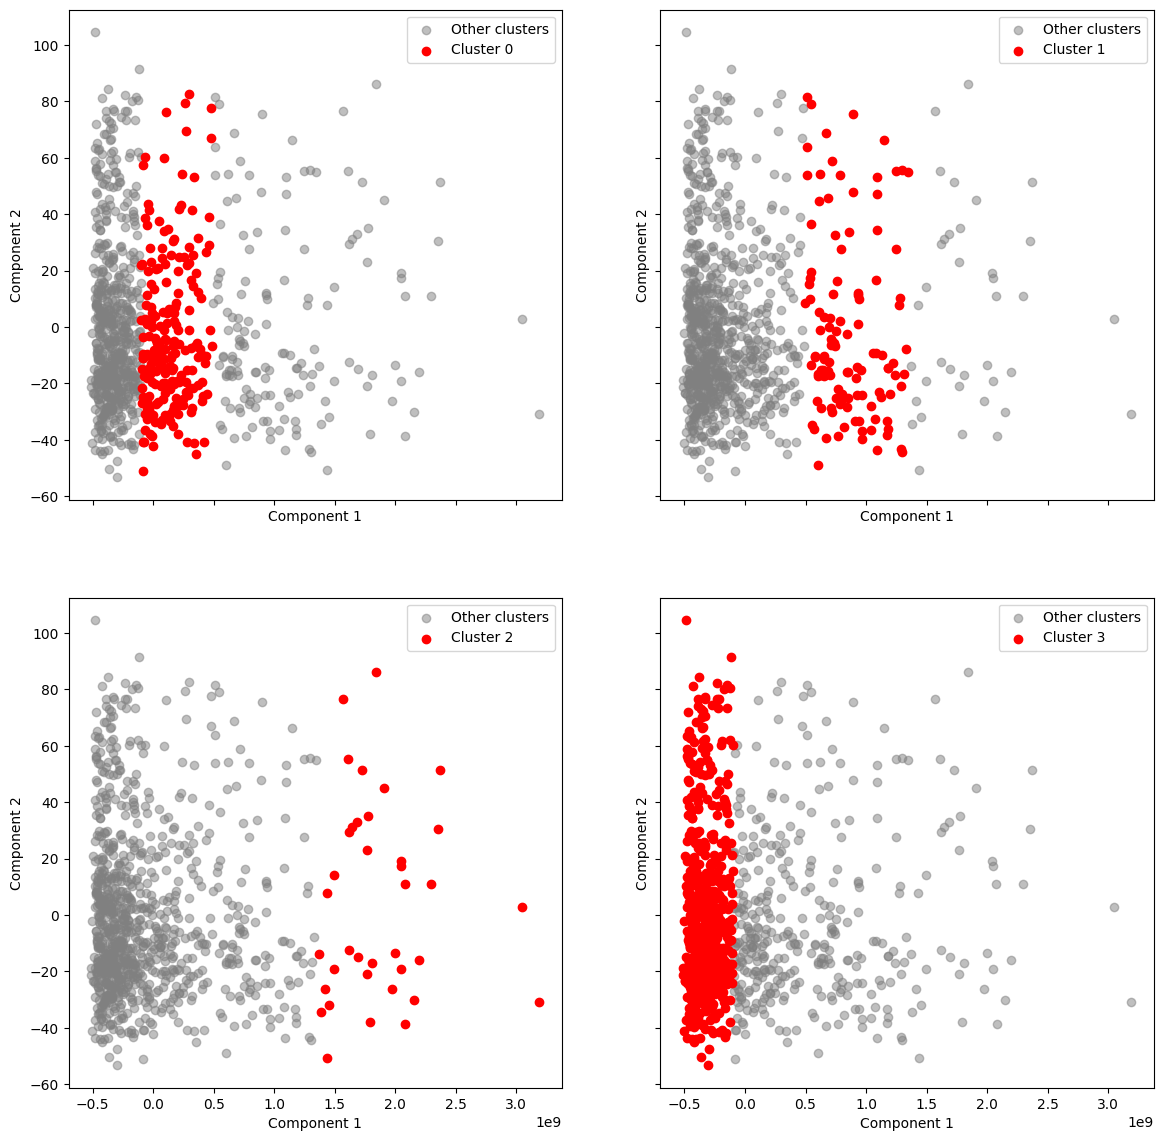

In [24]:
# Get the unique cluster assignments
unique_clusters = np.unique(clusters)

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14), sharex=True, sharey=True)

# Flatten the array of subplots to make it easier to iterate over
axs = axs.flatten()

# Iterate over the clusters
for i, cluster in enumerate(unique_clusters):
    # Select the data points belonging to the current cluster
    df_cluster = principal_components[clusters == cluster]
    
    # Select the data points belonging to other clusters
    df_other_clusters = principal_components[clusters != cluster]
    
    # Plot the data points belonging to other clusters in gray
    axs[i].scatter(df_other_clusters[:, 0], df_other_clusters[:, 1], c='gray', label='Other clusters', alpha=0.5)
    
    # Plot the data points belonging to the current cluster with a different color
    axs[i].scatter(df_cluster[:, 0], df_cluster[:, 1], c='red', label='Cluster {}'.format(cluster))
    
    # Set the x and y labels for the current subplot
    axs[i].set_xlabel('Component 1')
    axs[i].set_ylabel('Component 2')
    
    # Add a legend to the current subplot
    axs[i].legend()

plt.show()


In [25]:
# First, let's create a new dataframe with the cluster assignments as a column
clustered_df = spotify_songs_copy_df.copy()
clustered_df['cluster'] = clusters

                bpm  danceability_%  valence_%   energy_%  acousticness_%  \
cluster                                                                     
0        125.202899       66.314010  50.893720  64.570048       24.048309   
1        123.321739       64.278261  48.278261  64.904348       25.339130   
2        117.540541       62.027027  49.891892  60.513514       31.621622   
3        121.792580       68.052277  52.286678  64.283305       28.190556   

         instrumentalness_%  liveness_%  speechiness_%  \
cluster                                                  
0                  1.555556   17.739130       9.067633   
1                  0.669565   17.973913       8.373913   
2                  0.054054   15.405405       8.081081   
3                  1.865093   18.602024      10.983137   

         streams_numeric_cleaned  
cluster                           
0                   6.457436e+08  
1                   1.369015e+09  
2                   2.383958e+09  
3            

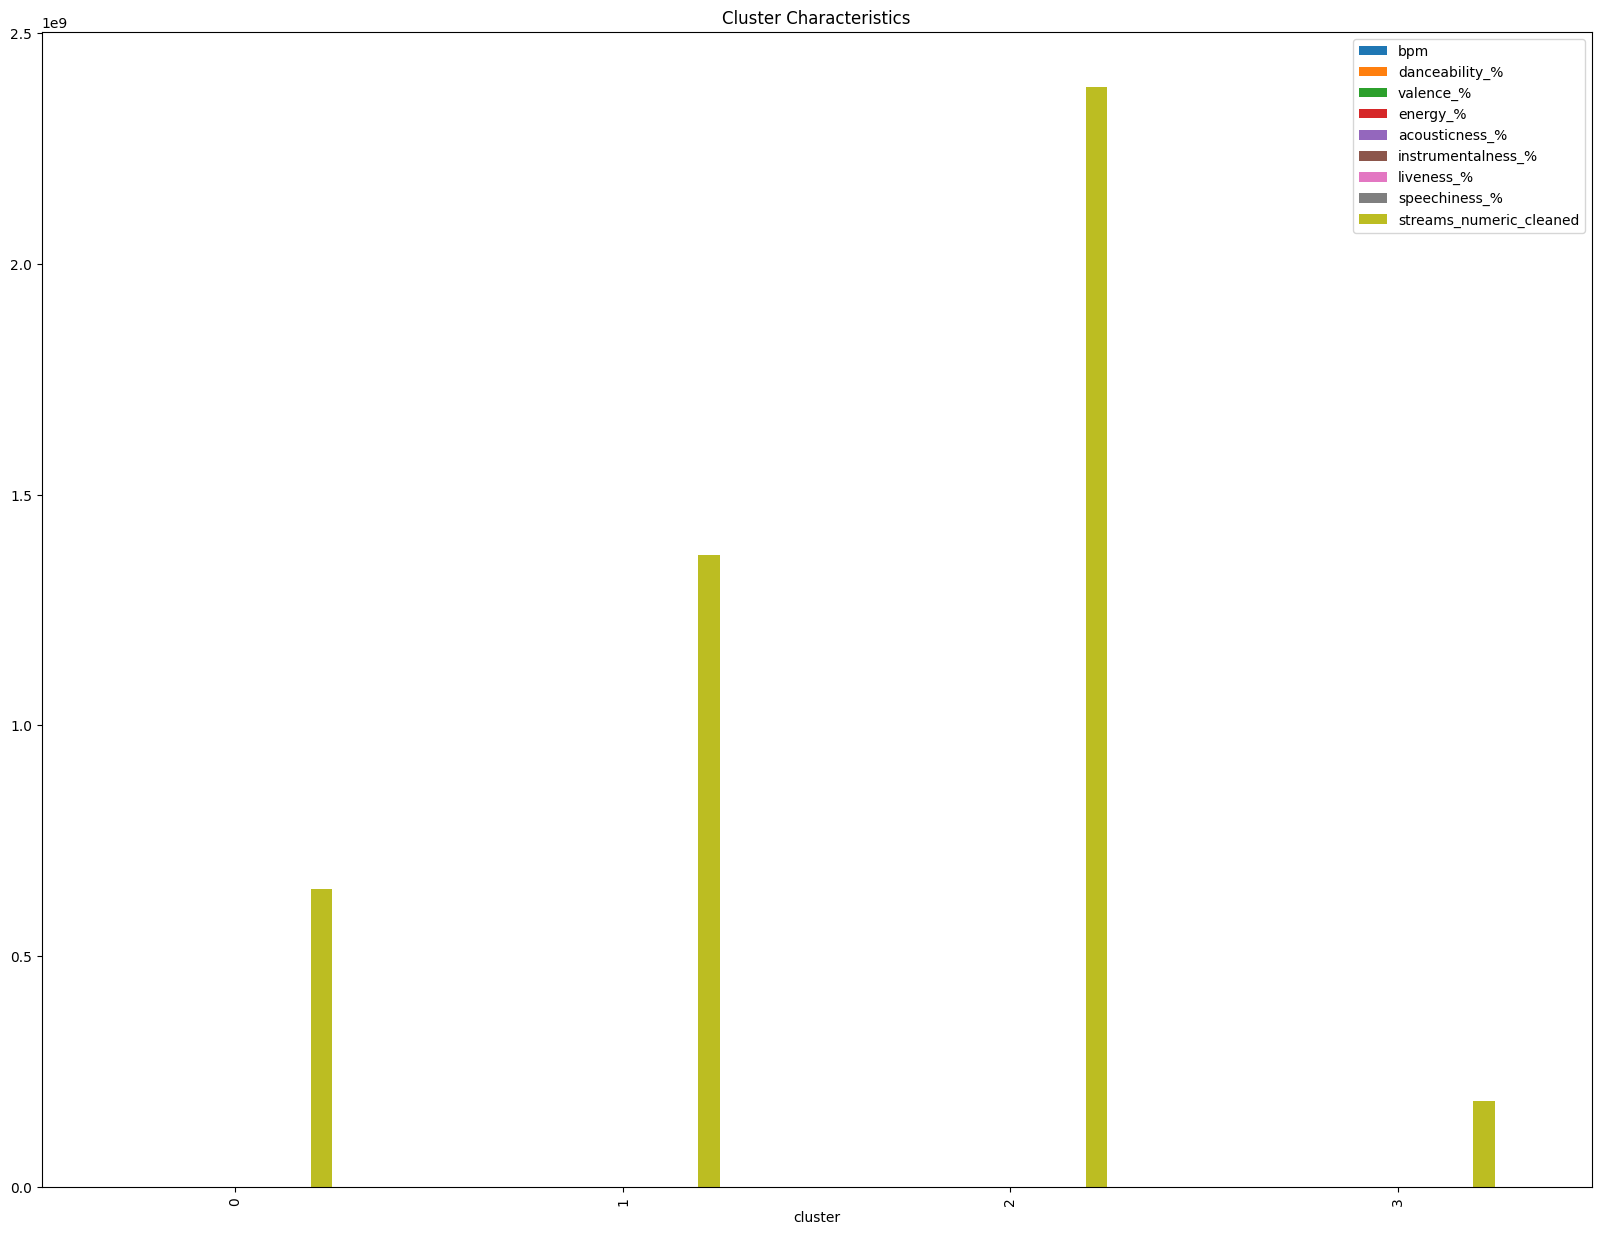

In [26]:
# Now, we can examine the characteristics of the individual clusters
# For example, we can group the data by cluster and compute the mean of each column
cluster_means = clustered_df.groupby('cluster').mean()
print(cluster_means)

# We can also compare the clusters to each other by creating a plot of the cluster means
# This can help us to see how the clusters differ from each other

cluster_means.plot(kind='bar',figsize=(20,15))
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

**Random forest classifier**

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


((666, 8), (666,))

In [50]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [51]:

model=RandomForestClassifier(n_estimators=10,random_state=42)

In [52]:
model.fit(x_train,y_train)

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [47]:
y_pred=model.predict(x_test)

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

In [48]:
print(accuracy_score(y_test,y_pred))

NameError: name 'y_pred' is not defined

In [49]:
classification_report(y_test,y_pred)

NameError: name 'y_pred' is not defined

In [71]:
report=classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.16      0.09      0.11        35
           1       0.64      0.84      0.73       179
           2       0.30      0.16      0.21        63
           3       1.00      0.11      0.20         9

    accuracy                           0.57       286
   macro avg       0.53      0.30      0.31       286
weighted avg       0.52      0.57      0.52       286

